In [227]:
import warnings
import json 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay

from jre_utils.config import asset_types
from jre_utils.datapath import model_ready_data_paths, model_output_data_paths, DATA_DIRECTORY_PATH
from jre_utils.process import get_most_active_municipalities
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

### Config


In [228]:
asset_type = "combined"
dataset_key = "transactions"
years_ahead = 2

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "gmean"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"

normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [229]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

In [230]:
id_columns = ["area_code", "area", "year"]

original_factor_columns = [
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_log_normalize_columns = [
    "population",
]

factor_normalize_columns = []

factor_maintain_columns = [
    "migrations_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
    + original_factor_columns
)

final_factor_columns = (
    factor_normalize_columns + factor_log_normalize_columns + factor_columns
)

In [231]:
# asset_types_to_train = asset_types
asset_types_to_train = ["building"]
asset_types_as_factors = list(set(asset_types_to_train + ["building"]))

core_log_normalize_columns = ["count", metric]
core_normalize_columns = ["count_growth", "yearly_price_growth", metric_pct_chg]
core_maintain_columns = ["metric_pct_chg_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

combined_core_columns = [
    f"{asset_type}_{column}"
    for column in core_columns
    for asset_type in asset_types_as_factors
]

In [232]:
feature_columns = factor_columns + combined_core_columns + ["land", "condo"]

### Dataset Prep


In [254]:
df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)
df = get_most_active_municipalities(df, count_column="building_count", n=1000)

df["area_code"] = df["area_code"].astype(str)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

# Split into Train and Eval
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

train_dfs = {
    asset_type: train_df[
        ~train_df[f"{asset_type}_{metric_pct_chg}"].isna()
    ].reset_index(drop=True)
    for asset_type in asset_types_to_train
}

eval_dfs = {
    asset_type: eval_df[~eval_df[f"{asset_type}_{metric_pct_chg}"].isna()].reset_index(
        drop=True
    )
    for asset_type in asset_types_to_train
}

# Finally
df = df.fillna(0)

for asset_type in asset_types_to_train:
    print(f"{asset_type} -> Train: {train_dfs[asset_type].shape}, Eval: {eval_dfs[asset_type].shape}")


building -> Train: (12112, 72), Eval: (2000, 72)


In [255]:
# df[df["area_code"] == "13101"][["year", "area_code", "area", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

<Axes: ylabel='Frequency'>

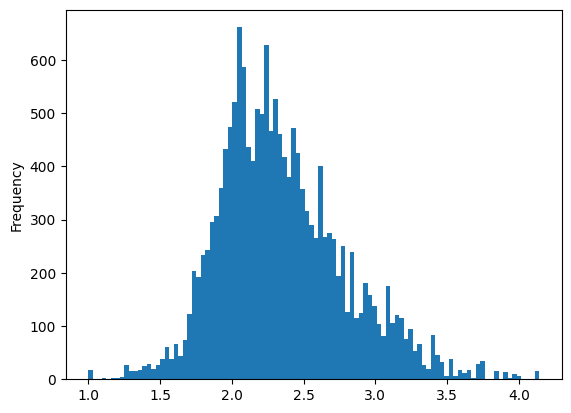

In [256]:
df["weight"].plot.hist(bins=100)

In [236]:
asset_type = "building"
tmp_train_df, tmp_eval_df = train_dfs[asset_type], eval_dfs[asset_type]
tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg = (
    f"{asset_type}_{metric}",
    f"{asset_type}_{metric_pct_chg}",
    f"{asset_type}_{normalized_metric_pct_chg}",
)

tmp_train_df[(tmp_train_df["area_code"] == "13102")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_unit_price_gmean,building_unit_price_gmean_pct_chg,building_unit_price_gmean_pct_chg_normalized_yearly
26,2007,2.930576e+06,0.340367,0.945009
116,2008,2.615646e+06,0.346098,0.819502
312,2009,1.862297e+06,-0.364528,-0.922257
1279,2010,1.439064e+06,-0.449825,-0.781421
2938,2011,1.486421e+06,-0.201835,-0.623724
3329,2012,1.375874e+06,-0.043910,-0.168216
4863,2013,1.722702e+06,0.158959,0.349495
5639,2014,2.003999e+06,0.456528,1.121206
6541,2015,2.250190e+06,0.306198,0.625337
7413,2016,2.529195e+06,0.262074,0.387583


In [237]:
tmp_eval_df[(tmp_eval_df["area_code"] == "13102")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_unit_price_gmean,building_unit_price_gmean_pct_chg,building_unit_price_gmean_pct_chg_normalized_yearly
196,2021,2.816571e+06,-0.053462,-0.274119
1934,2022,3.951694e+06,0.228788,0.391885


In [238]:
idx = tmp_eval_df[(tmp_eval_df["area_code"] == "13102")].index[-2]
row = tmp_eval_df.iloc[idx]
target = row[tmp_normalized_metric_pct_chg]
area_code, year = row["area_code"], row["year"]
window = (
    df[(df["area_code"] == area_code) & (df["year"] <= year - years_ahead)]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window["time_diff"] = year - window["year"]
window[factor_columns + combined_core_columns]

Target: -0.2741193205598468


,population_log_normalized_yearly,migrations_is_available,taxable_income_growth,taxable_income_per_taxpayer_growth,net_migration_ratio,new_dwellings_ratio,taxpayer_count_growth,building_count_log_normalized_yearly,building_unit_price_gmean_log_normalized_yearly,building_count_growth_normalized_yearly,building_yearly_price_growth_normalized_yearly,building_unit_price_gmean_pct_chg_normalized_yearly,building_metric_pct_chg_is_available
11240,1.094578,1,0.055433,0.003171,0.024555,0.028343,0.052097,0.499304,3.772401,-0.164742,0.087632,0.625337,1.0
12406,1.110245,1,0.081736,0.038480,0.031632,0.070795,0.041653,0.501461,3.840590,-0.149857,0.161446,0.387583,1.0
14195,1.130387,1,0.082041,0.026958,0.033346,0.023577,0.053637,0.357890,3.856103,-0.575711,0.149185,0.430439,1.0
15505,1.151447,1,0.075667,0.019827,0.023834,0.044978,0.054755,0.490776,3.996312,0.322578,0.033797,0.422218,1.0
17131,1.166419,1,0.108315,0.066440,0.024260,0.017821,0.039266,0.431280,3.871725,-0.303215,-0.257691,-0.002194,1.0


In [239]:
window[["year", "area_code", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

In [240]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[tmp_normalized_metric_pct_chg],
    weight_column="weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    shift=years_ahead,
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[tmp_normalized_metric_pct_chg],
    weight_column="weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead,
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 15) (1,) [-0.23916518] [3.65628021]
1 (1, 15) (1,) [1.33103341] [3.22549216]
2 (1, 15) (1,) [-0.94234526] [1.90772947]
3 (1, 15) (1,) [1.59928461] [2.90101942]
0 torch.Size([5, 15]) torch.Size([1]) tensor([-0.2392]) tensor([3.6563])
1 torch.Size([5, 15]) torch.Size([1]) tensor([1.3310]) tensor([3.2255])
2 torch.Size([5, 15]) torch.Size([1]) tensor([-0.9423]) tensor([1.9077])
3 torch.Size([5, 15]) torch.Size([1]) tensor([1.5993]) tensor([2.9010])


In [241]:
BATCH_SIZE = 256

In [242]:
train_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        train_dfs[asset_type],
        metrics=[f"{asset_type}_{normalized_metric_pct_chg}"],
        weight_column="weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
        shift=years_ahead,
    )
    for asset_type in asset_types_to_train
}

eval_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        eval_dfs[asset_type],
        metrics=[f"{asset_type}_{normalized_metric_pct_chg}"],
        weight_column="weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
        shift=years_ahead,
    )
    for asset_type in asset_types_to_train
}

In [243]:
train_dataset = ConcatDataset(list(train_datasets.values()))
eval_dataset = ConcatDataset(list(eval_datasets.values()))

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [244]:
len(train_dataloader)

48

### Building the Transformer Model


In [245]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [246]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)

In [247]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)

        print("Loss:", loss.item())

        break

torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.8618004322052


In [141]:
learning_rate = 1e-4  # 3e-4
weight_decay = 1  # 1
num_epochs = 30

In [142]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear",  # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [143]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 8.9639, Eval Loss: 7.6831
Train R^2: 0.0631, Eval R^2: 0.2325
Epoch: 1
Train Loss: 7.5192, Eval Loss: 7.2289
Train R^2: 0.2145, Eval R^2: 0.2791
Epoch: 2
Train Loss: 7.2657, Eval Loss: 6.9598
Train R^2: 0.2415, Eval R^2: 0.3057
Epoch: 3
Train Loss: 7.1439, Eval Loss: 6.9504
Train R^2: 0.2551, Eval R^2: 0.3067
Epoch: 4
Train Loss: 7.0297, Eval Loss: 6.8967
Train R^2: 0.2684, Eval R^2: 0.3126
Epoch: 5
Train Loss: 6.9382, Eval Loss: 6.9241
Train R^2: 0.2793, Eval R^2: 0.3100
Epoch: 6
Train Loss: 6.8539, Eval Loss: 6.9512
Train R^2: 0.2879, Eval R^2: 0.3102
Epoch: 7
Train Loss: 6.8456, Eval Loss: 7.0214
Train R^2: 0.2882, Eval R^2: 0.3034
Epoch: 8
Train Loss: 6.7957, Eval Loss: 6.8865
Train R^2: 0.2943, Eval R^2: 0.3157
Epoch: 9
Train Loss: 6.7007, Eval Loss: 6.7861
Train R^2: 0.3044, Eval R^2: 0.3253
Epoch: 10
Train Loss: 6.7357, Eval Loss: 6.8157
Train R^2: 0.2987, Eval R^2: 0.3227
Epoch: 11
Train Loss: 6.6692, Eval Loss: 6.7755
Train R^2: 0.3074, Eval R^2: 0.3261
Ep

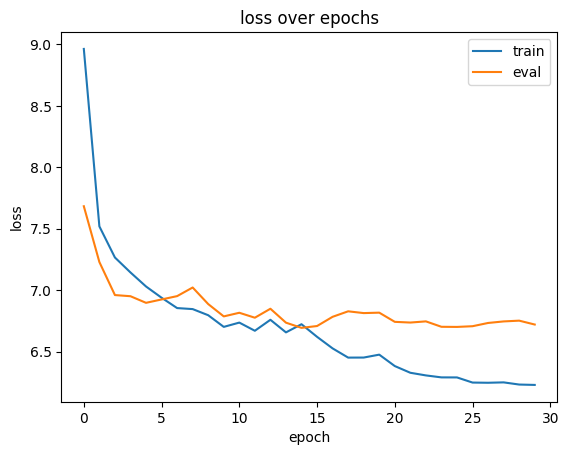

In [144]:
# Plot MSE
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss over epochs")
plt.legend()
plt.show()

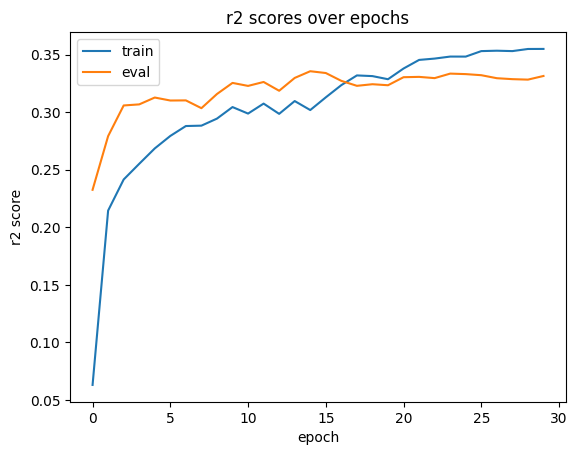

In [145]:
# Plot R2 scores
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

In [146]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 6.7199
Eval R2: 0.3314


In [135]:
years = [2020, 2021, 2022]  # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_returns(
        model, row["area_code"], row["year"], row["asset_type"]
    ),
    axis=1,
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
35359,2020,1610,-0.225865,-0.083333,-0.183792
35360,2020,1559,-0.126823,-0.056604,-0.163653
35361,2020,40345,0.299982,0.254167,0.212992
35362,2020,11211,-0.082083,0.255589,0.215278
35363,2020,27204,-0.095639,-0.153846,-0.236919
...,...,...,...,...,...
43476,2022,19202,-0.279620,0.291667,0.122768
43477,2022,40205,-0.291991,-0.133333,-0.361959
43478,2022,35344,-0.761920,1.200000,1.158755
43479,2022,33215,0.369334,-0.191489,-0.428288


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

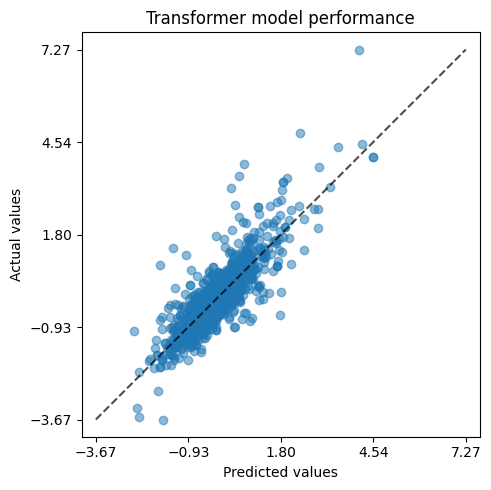

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

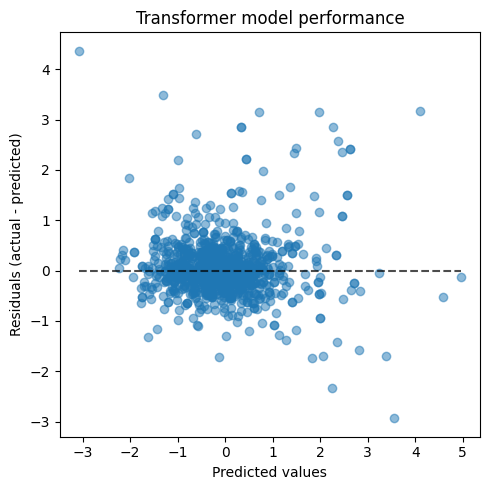

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

In [221]:
model

TimeSeriesTransformerModel(
  (embedding): Linear(in_features=11, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=256, out_features=1, bias=True)
)